In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [38]:
data1 = pd.read_csv("omni_ussd.csv",  parse_dates = ['Date', 'DateMinute'])
data2 = pd.read_csv("omni_ussd_2.csv",  parse_dates = ['Date', 'DateMinute'])


In [39]:
data = pd.concat([data1, data2])

data['Hour'] = data['Hour'].astype('string')
data['Month_Name'] = data['Month_Name'].astype('string')
data['_id'] = data['_id'].astype('string')

data.dtypes

Date           datetime64[ns, UTC]
DateHour                    object
DateMinute     datetime64[ns, UTC]
Hour                        string
Month                       object
Month_Name                  string
_id                         string
code                        object
count                        int64
status_flag                 object
trans_type                  object
dtype: object

In [40]:
data.head(2)

,Date,DateHour,DateMinute,Hour,Month,Month_Name,_id,code,count,status_flag,trans_type
0,2022-08-05 00:00:00+00:00,2022-08-05T01:00:00.000Z,2022-08-05 01:41:00+00:00,01 AM,2022-08-01T00:00:00.000Z,August,62ec4b94ee7938f93b111c9a,AH,1,Success,Mpesa Pay To Till
1,2022-08-05 00:00:00+00:00,2022-08-05T01:00:00.000Z,2022-08-05 01:41:00+00:00,01 AM,2022-08-01T00:00:00.000Z,August,62ec4b94ee7938f93b111c9b,AH,7,Success,Mpesa B2C


In [41]:
data.shape

(79121, 11)

In [42]:
data = data.drop_duplicates()

In [43]:
data.shape

(61848, 11)

In [44]:
drop_cols = ['DateHour', 'Month', 'trans_type']
data.drop(drop_cols, axis=1, inplace=True)

In [45]:
data.head(5)

,Date,DateMinute,Hour,Month_Name,_id,code,count,status_flag
0,2022-08-05 00:00:00+00:00,2022-08-05 01:41:00+00:00,01 AM,August,62ec4b94ee7938f93b111c9a,AH,1,Success
1,2022-08-05 00:00:00+00:00,2022-08-05 01:41:00+00:00,01 AM,August,62ec4b94ee7938f93b111c9b,AH,7,Success
2,2022-08-05 00:00:00+00:00,2022-08-05 01:41:00+00:00,01 AM,August,62ec4b94ee7938f93b111c9c,RH,1,Fail
3,2022-08-05 00:00:00+00:00,2022-08-05 01:42:00+00:00,01 AM,August,62ec4bd2ee7938f93b111c9e,0,11,Success
4,2022-08-05 00:00:00+00:00,2022-08-05 01:42:00+00:00,01 AM,August,62ec4bd2ee7938f93b111c9f,AH,8,Success


In [46]:
## Aggregating all transactions by the hour
data_agg = data.groupby(by=["DateMinute","Hour", "Month_Name"], as_index=False).agg(
    transaction_count = ("count", "sum"))

In [48]:
data_agg.head(3)
drop_cols = ['Hour', 'Month_Name']
data_agg.drop(drop_cols, axis=1, inplace=True)

In [51]:
data_agg.head(3)

,DateMinute,transaction_count
0,2022-08-05 01:41:00+00:00,9
1,2022-08-05 01:42:00+00:00,20
2,2022-08-05 01:43:00+00:00,15


In [52]:
data_agg.to_csv("agg_data.csv")


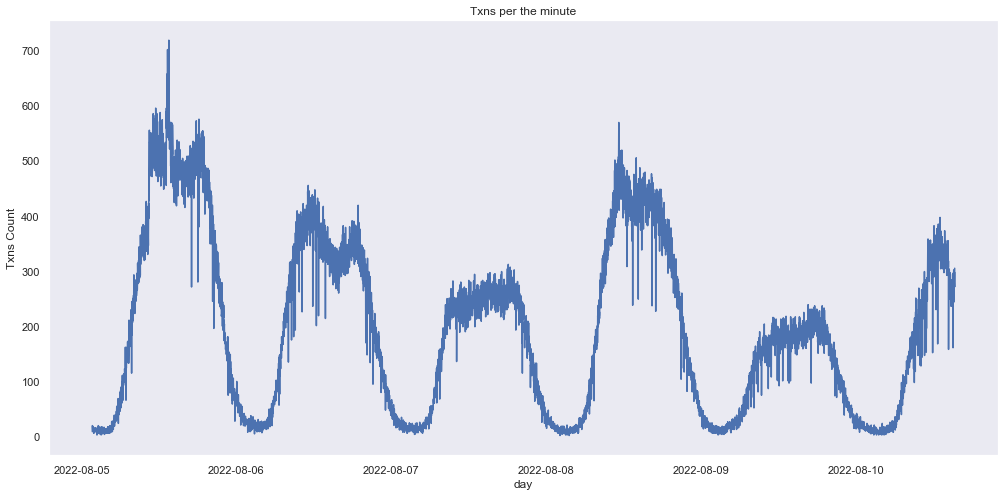

In [54]:
plt.figure(figsize=(17, 8))
plt.plot(data_agg.DateMinute,data_agg.transaction_count)
plt.title('Txns per the minute')
plt.ylabel('Txns Count')
plt.xlabel('day')
plt.grid(False)
plt.show()

In [55]:
#MOVING AVERAGE
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

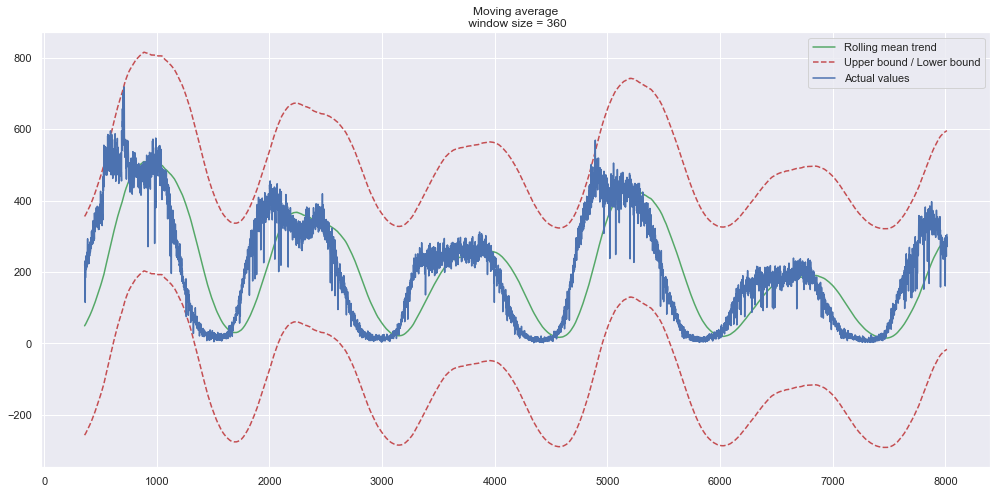

In [70]:
#Smooth by the previous days 
plot_moving_average(data_agg.transaction_count, 360, plot_intervals=True)

In [71]:
#EXPONENTIAL SMOOTHING
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [72]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

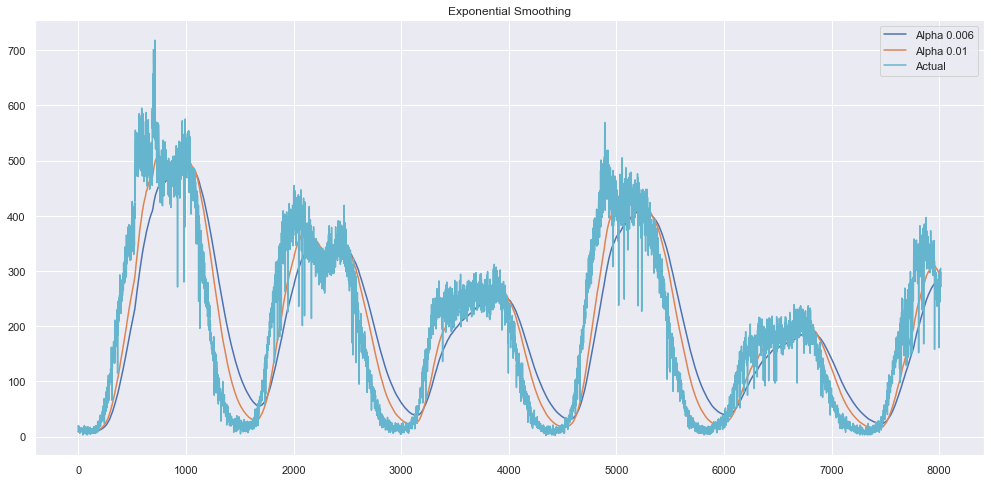

In [79]:
plot_exponential_smoothing(data_agg.transaction_count, [0.006, 0.01])

In [80]:
#DOUBLE EXPONENTIAL SMOOTHING
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [81]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

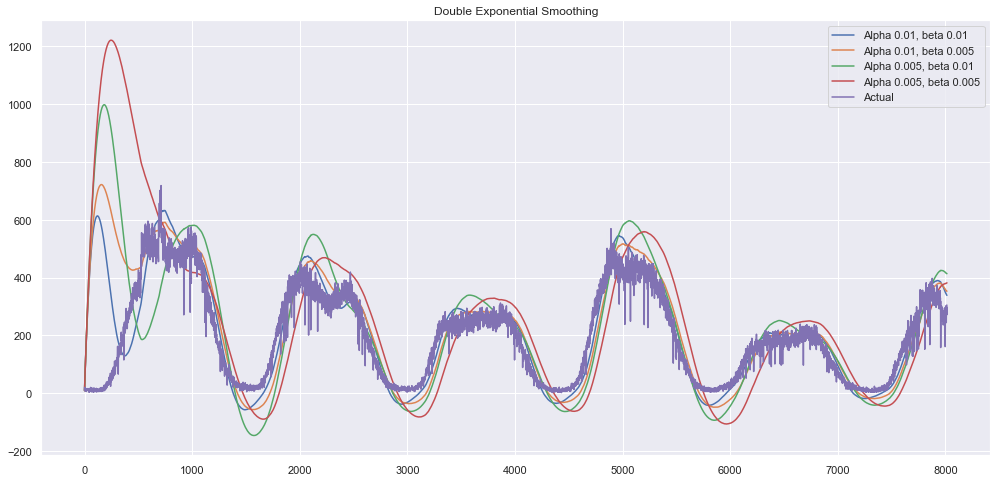

In [89]:
plot_double_exponential_smoothing(data_agg.transaction_count, alphas=[0.01, 0.005], betas=[0.01, 0.005])

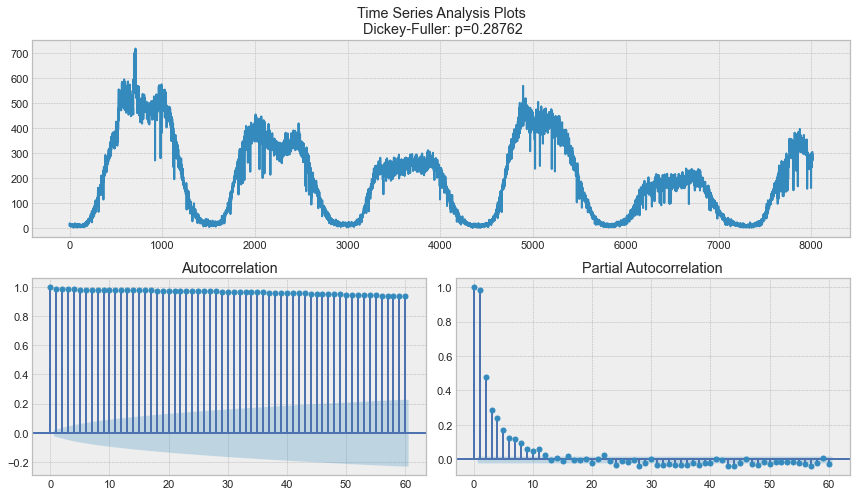

In [94]:
#STATIONARITY TEST checking whether unit root is present i.e. not stationary
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data_agg.transaction_count, lags=60)

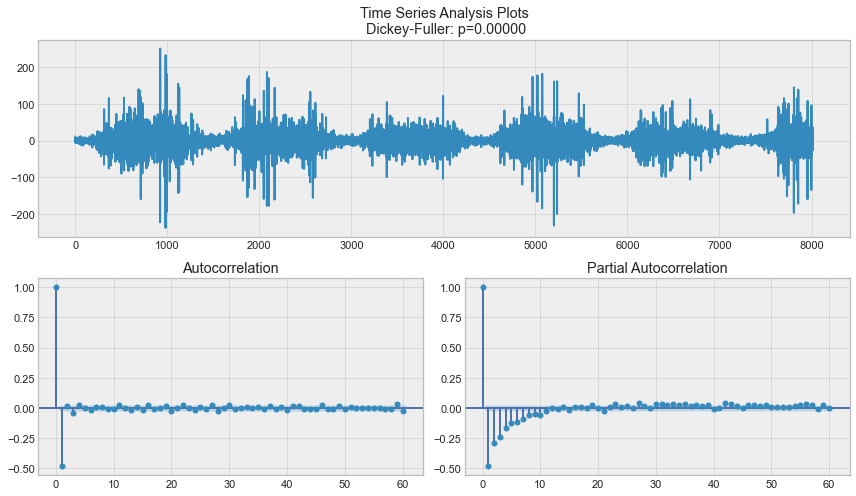

In [96]:
#make it stationary
data_diff = data_agg.transaction_count - data_agg.transaction_count.shift(1)

tsplot(data_diff[1:], lags=60)

In [97]:
#SARIMA
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data_agg.transaction_count, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

  0%|          | 0/625 [00:00<?, ?it/s]

In [99]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data_agg.transformation_count, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

NameError: name 'result_table' is not defined

In [ ]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data_agg = series.copy().rename(columns = {'CLOSE': 'actual'})
    data_agg['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data_agg['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data_agg.shape[0], end=data_agg.shape[0] + n_steps)
    forecast = data_agg.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data_agg['actual'][s+d:], data_agg['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data_agg.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data_agg, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 5)
print(best_model.predict(start=data_agg.transformation_count.shape[0], end=data_agg.transformation_count.shape[0] + 5))
print(mean_absolute_percentage_error(data_agg.transformation_count[s+d:], best_model.fittedvalues[s+d:]))

In [ ]:
comparison = pd.DataFrame({'actual': [18.93, 19.23, 19.08, 19.17, 19.11, 19.12],
                          'predicted': [18.96, 18.97, 18.96, 18.92, 18.94, 18.92]}, 
                          index = pd.date_range(start='2018-06-05', periods=6,))

In [ ]:
comparison.head()

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()